In [21]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.getcwd()))
import cvxpy as cp
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from survLime.datasets.load_datasets import RandomSurvivalData
from survLime import survlime_tabular
from survLime.scripts.experiment_1 import create_clusters
from survLime.utils.generic_utils import compare_survival_times
#np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Create clusters can be found in scripts/experiment_1
cluster_0, cluster_1 = create_clusters()
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(cluster_0[0],
                                                            cluster_0[1], test_size=0.1)
times = [x[1] for x in y_train_1]
times_to_fill = list(set(times))
times_to_fill.sort() 
m = len(times_to_fill)

In [23]:
# Train bb model
columns =[f'feat_{i}' for i in range(x_train_1.shape[1])]
model = CoxPHSurvivalAnalysis(alpha=0.0001)
model.fit(x_train_1, y_train_1)
model.feature_names_in_ = columns # This is needed in order to compare survival times later

# Obtain a test point to use for prediction
test_point = x_test_1[0]

In [24]:
# We instantiate an explainer (found in survlime_tabular)

# ['one','two',' three', 'four', 'five']

explainer = survlime_tabular.LimeTabularExplainer(x_train_1, y_train_1,
                                                  feature_names= columns,
                                                  class_names=None, 
                                                  categorical_features=None,
                                                  verbose=True, discretize_continuous=False)
num_neighbours = 1000
# From here we are only using log_correction, Ho_t_ and inverse 
H_i_j_wc, weights, log_correction, Ho_t_, scaled_data, inverse, distances = explainer.explain_instance(test_point
                                                                ,model.predict_cumulative_hazard_function,
                                                            num_samples = num_neighbours)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [25]:
cbh_model = model.cum_baseline_hazard_.y.reshape(m, 1)
cbh_na = Ho_t_.reshape(m, 1)
diff = np.abs(cbh_na - cbh_model)
print(diff.max())

1.673144683318287


## From this cell onwards we construct the matrices
We need 
* H
* H0
* b
* weights 
* delta_t

In [26]:
# Constants
epsilon = 0.000001
m = len(times_to_fill)

# Variable of interest
b = cp.Variable(shape=(scaled_data.shape[1],1))

# Compute the H for all the neighbours
yss = model.predict_cumulative_hazard_function(scaled_data, return_array=True)

H = yss.copy()
LnH = np.log(H)

# Baseline cumulative hazard 
#H0 = np.reshape(Ho_t_, (m,1))
H0 = model.cum_baseline_hazard_.y.reshape(m, 1)
LnH0 = np.log(H0)

# Compute the log correction
logs = np.reshape(log_correction, (num_neighbours, m))

# Distance weights
w = np.reshape(weights, (num_neighbours,1))

# Time differences
t = times_to_fill.copy()
t.append(t[-1]+1)
delta_t = [t[i+1] - t[i] for i in range(m)]
delta_t = np.reshape(np.array(delta_t), newshape=(m, 1))

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [27]:
# Matrices to produce the propper sizes
ones_N = np.ones(shape=(num_neighbours, 1))
ones_m_1 = np.ones(shape=(m, 1))

B = np.dot(ones_N, LnH0.T)
C = LnH-B

Z = scaled_data@b
D = Z@ones_m_1.T

E = C - D
E_sq = cp.square(E)

V_sq = cp.square(logs)

F = cp.multiply(E_sq, V_sq)
G = F@delta_t

funct = G.T@w
objective = cp.Minimize(funct)
prob = cp.Problem(objective)
result = prob.solve(verbose=True, max_iter=10000)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 29 10:29:45 AM: Your problem has 5 variables, 0 constraints, and 0 parameters.
(CVXPY) Aug 29 10:29:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 29 10:29:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 29 10:29:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 29 10:29:45 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 29 10:29:45 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing 

In [28]:
print(funct.value)
print(b.value)
print(model.coef_)

[[3.84291455e-20]]
[[ 0.00425799]
 [ 0.08725393]
 [-0.15234782]
 [ 0.02343486]
 [-0.01778417]]
[ 0.00425799  0.08725393 -0.15234782  0.02343486 -0.01778417]


[1e-06, 0.1, -0.15, 1e-06, 1e-06]
[0.004257991745723135, 0.08725392705255614, -0.15234781562571004, 0.023434862657731113, -0.017784170851646016]
[ 0.00425799  0.08725393 -0.15234782  0.02343486 -0.01778417]


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


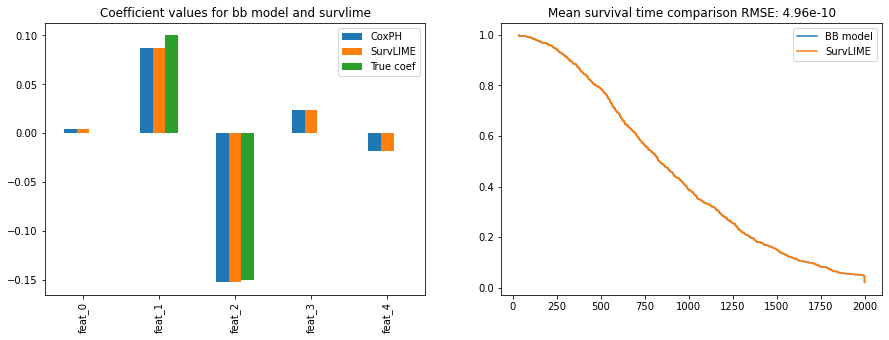

In [30]:
# Coefficient coppied from survLime/scripts/experiment_1.create_clusters
coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]
#coefficients = [0.2]
values = [x[0] for x in b.value]
print(coefficients)
print(values)
print(model.coef_)
compare_survival_times(model, values, x_train_1, y_train_1, x_test_1, true_coef=coefficients)